In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

In [4]:
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import seaborn as sns
from colour import Color


from IPython.display import HTML, display
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime as dt
import sklearn
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn import preprocessing

from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, FactorRange, CDSView, Label, LabelSet, Range1d
from bokeh.palettes import GnBu3, OrRd3,Spectral6, RdBu3
from bokeh.plotting import figure, show,  output_file
output_notebook()

import os
import random
import folium

from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


df = pd.read_csv('listingsCPH.csv',low_memory=False)
df['host_since'] = pd.to_datetime(df['host_since'])


Loading BokehJS ...

In [5]:
df['price'] = df['price'].str.replace(r',', '')
df['price'] = df['price'].str.replace(r'$', '')
print('punctuation in price column removed')
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_review'] = pd.to_datetime(df['last_review'])
df['calendar_last_scraped'] = pd.to_datetime(df['calendar_last_scraped'])

df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(r'%', '')

df = df.astype({'price': 'float','neighbourhood_cleansed': 'category'})

punctuation in price column removed


In [6]:
# Only take relevant attributes for this analysis. Add if neccessary 
dfc = pd.DataFrame (df, columns = ['last_review', 
                                   'neighbourhood_cleansed', 
                                   'host_name',
                                   'availability_365',
                                   'host_url',
                                   'listing_url',
                                   'latitude', 
                                   'longitude',
                                   'host_picture_url',
                                   'host_id',
                                   'id',
                                   'host_total_listings_count',
                                   'price', 
                                   'host_since',
                                   'room_type', 
                                   'maximum_nights',
                                   'minimum_nights',
                                   'calendar_last_scraped',
                                   'accommodates',
                                   'host_acceptance_rate',
                                   'reviews_per_month'
                                  ])

In [7]:
# The total sum af property types. 
Sum_P = len(dfc['room_type'])
Enti = len(dfc[(dfc['room_type'] == 'Entire home/apt')])
Priv = len(dfc[(dfc['room_type'] == 'Private room')])
Sha = len(dfc[(dfc['room_type'] == 'Shared room')])
hot = len(dfc[(dfc['room_type'] == 'Hotel room')])


# Create the right dataframe for this plot
dHomes = pd.DataFrame({'Propertytype': 'Property type',
                       'Entire Homes': (Enti/Sum_P)*100,
                        'Private Rooms': (Priv/ Sum_P)*100,
                       'Hotel Rooms': (hot/Sum_P)*100, 
                        'Shared Rooms': (Sha/Sum_P)*100}, index=[0])

In [8]:
colors = ["#CAF1DE", "#E1F8DC","#FFE7C7", '#D3D3D3']    

Cat =["Entire Homes","Private Rooms", "Shared Rooms", 'Hotel Rooms']

Propertytype = dHomes["Propertytype"]

x_label = "% of host listings" 

sourceDh = ColumnDataSource(dHomes)

In [9]:
pHomes = figure(y_range=Propertytype, plot_height=300, plot_width =900, x_axis_label = x_label, title="% of host listings by property Type",
           toolbar_location=None, tools="hover", tooltips="$name @$name%")

pHomes.hbar_stack(Cat, y='Propertytype', height=0.8, source=sourceDh, color=colors, 
             legend=[dict(value=["Entire Homes"]),dict(value=["Private Rooms"]), dict(value=["Shared Rooms"]), dict(value=["Hotel Rooms"])])

pHomes.legend.location = "top_right"
pHomes.legend.orientation = "vertical"
pHomes.xgrid.visible = False
pHomes.ygrid.visible = False

#labels = LabelSet(y='Propertytype', text='Cat', level='glyph',
#              x_offset=5, y_offset=5, source=sourceDh)

#pHomes.add_layout(labels)
show(pHomes) 



In [10]:
size_beforeProp = len(dfc)
dfc = dfc[(dfc['room_type'] == 'Entire home/apt')]
size_afterProp = len(dfc)
print(str(size_beforeProp-size_afterProp) + " rows are removed, these are hosts with property type private, shared or hotel rooms.")

4492 rows are removed, these are hosts with property type private, shared or hotel rooms.


In [11]:
chosen_attributes = ['id','price','last_review', 'neighbourhood_cleansed','host_total_listings_count', 'host_name','availability_365','host_url']

In [12]:
data_new_hosts_clean = dfc
size_before_Price = len(data_new_hosts_clean)
data_new_hosts_clean = data_new_hosts_clean.dropna(axis=0, subset=['price'])
size_after_Price = len(data_new_hosts_clean)
print(str(size_before_Price-size_after_Price) + " na rows removed from data")

#data_new_hosts_clean['price'] = data_new_hosts_clean['price'].str.replace(r',', '')
#data_new_hosts_clean['price'] = data_new_hosts_clean['price'].str.replace(r'$', '')
#print('punctuation in price column removed')

0 na rows removed from data


In [13]:
data_price = pd.DataFrame (data_new_hosts_clean, columns = chosen_attributes)

In [14]:
data_price = data_price.astype({'price': 'float','neighbourhood_cleansed': 'category'})

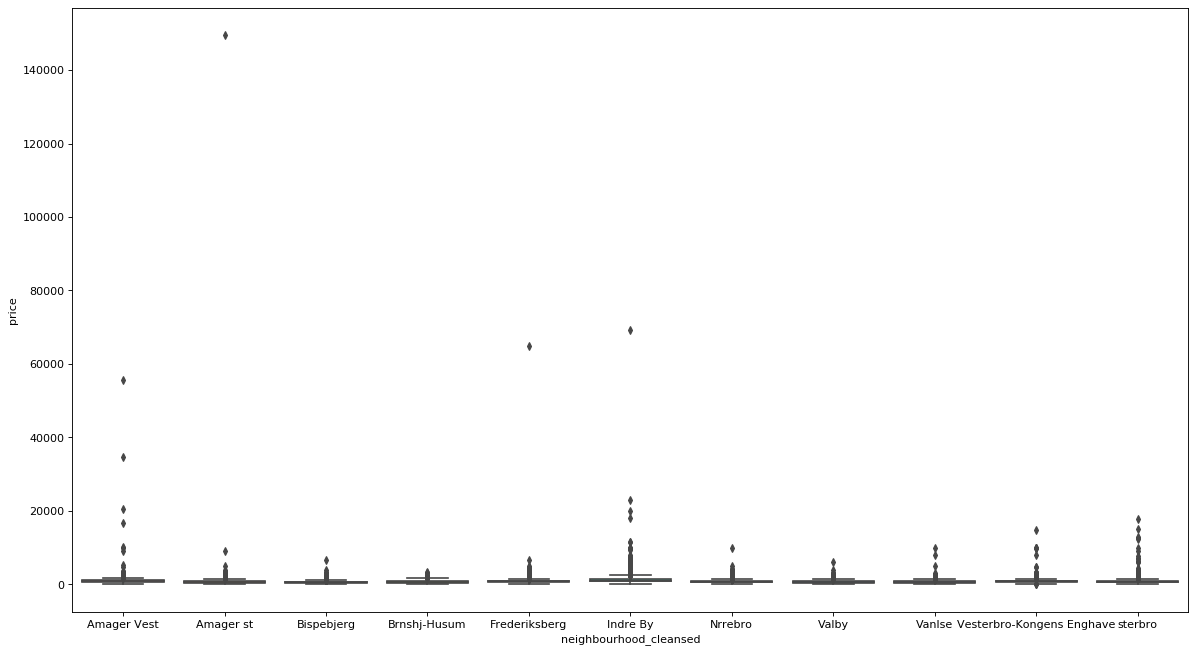

In [15]:
fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.boxplot(x="neighbourhood_cleansed", y="price", data=data_price)

In [16]:
condition1 = data_price['price'] <= 5000
data_price_filter = data_price[condition1]

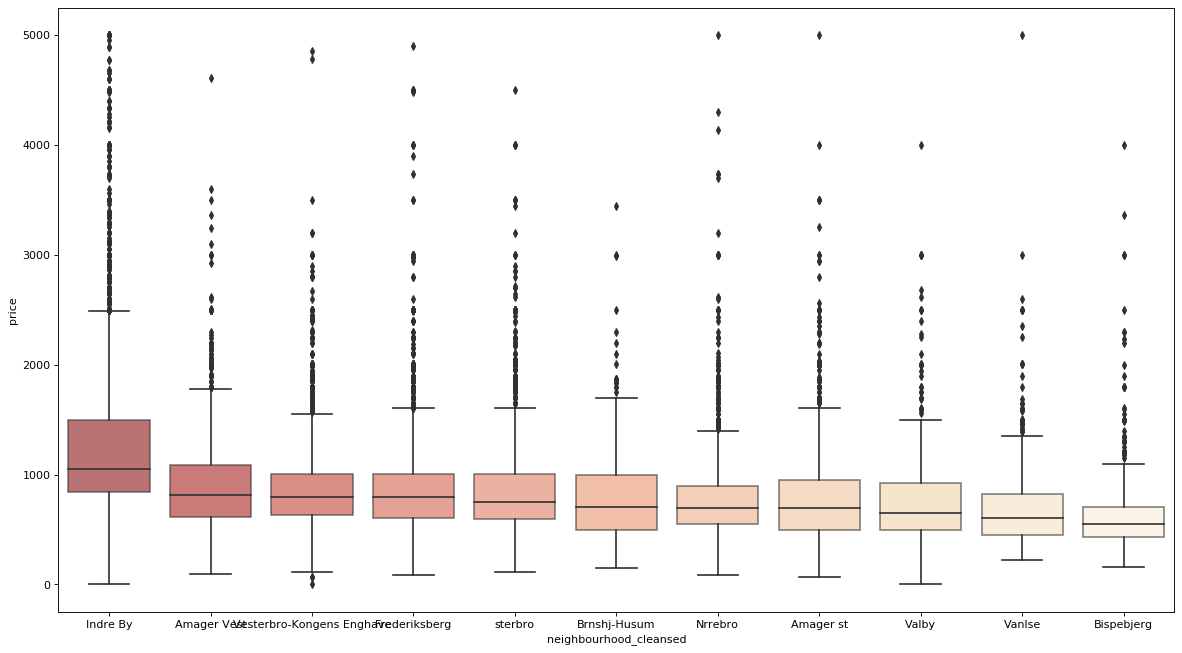

In [17]:
fig =plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')

item_order = data_price_filter.groupby(by=['neighbourhood_cleansed'])['price'].median().sort_values(ascending=False).index

ax = sns.boxplot(x="neighbourhood_cleansed", y="price", 
                 data=data_price_filter, order=item_order,palette="OrRd_r",boxprops=dict(alpha=.6))

In [18]:
#No duplicates of hosts
#heatdata = dfc.drop_duplicates(subset=['host_id'])

# If there are any NA's, ignore these
heatdata = dfc.dropna(axis=0, subset=['latitude', 'longitude'])

In [19]:
map_CPHheat = folium.Map(location=[55.672163978, 12.568164394], 
                    zoom_start = 12,
                    tiles = "Stamen Terrain")

# Add a marker
folium.Marker([55.672163978, 12.568164394], popup='Copenhagen City Hall', icon=folium.Icon(color='lightgray', icon='building', prefix='fa')).add_to(map_CPHheat)

# Ensure the datatype is float
heatdata['latitude'] = heatdata['latitude'].astype(float)
heatdata['longitude'] = heatdata['longitude'].astype(float)

# List comprehension to make out list of lists
heatdata = [[row['latitude'],row['longitude']] for index, row in heatdata.iterrows()]

gradient = {.40: '#F5F5DC', .66: '#ffeeed', 1: 'red'}

# Plot on the map
HeatMap(heatdata, max_opacity=0.8, radius = 7, max_zoom=16, gradient=gradient).add_to(map_CPHheat)

# Display the map
map_CPHheat